In [ ]:

import cv2
import numpy as np
from skimage import img_as_ubyte, io
from skimage.color import rgb2gray
from skimage.filters import gaussian, median
from skimage.morphology import disk
import os
import glob
from skimage import io  # or you can use PIL from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def preprocess_image(image_path):
    # Load image
    image_rgb = io.imread(image_path)

    # Check if image has 4 channels (RGBA) and discard the alpha channel if present
    if image_rgb.shape[-1] == 4:
        image_rgb = image_rgb[:, :, :3]  # Keep only the RGB channels

    # Convert to grayscale
    image_gray = rgb2gray(image_rgb)

    # Convert to 8-bit unsigned integer format
    image_gray = img_as_ubyte(image_gray)

    # Apply Gaussian filter to reduce noise
    image_filtered = gaussian(image_gray, sigma=1.0)

    # Apply Median filter for further noise reduction
    image_filtered = median(image_filtered, disk(3))

    return image_filtered

In [ ]:



parent_directory = 'dataset_combined'

# Use glob to get all image file paths in all subdirectories
imgPath = glob.glob(os.path.join(parent_directory, '**', '*.png'), recursive=True)  # You can adjust the file type

preprocess = []
for img in imgPath:
    preprocess.append(preprocess_image(img))
    print(f"{img} =====>{preprocess_image(img)}")


In [ ]:
import numpy as np
from skimage.measure import shannon_entropy
from skimage.transform import downscale_local_mean

def extract_texture_features(image, downscale_factor=2):
    # Downsample the image to reduce processing time (optional)
    if downscale_factor > 1:
        image = downscale_local_mean(image, (downscale_factor, downscale_factor))

    # Ensure the image is 2D
    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D array (grayscale image).")

    # Calculate the entropy of the entire image
    entropy_value = shannon_entropy(image)

    return entropy_value


In [ ]:
texture_features = []

# Assuming `flatten_features` is a list or array of 2D images
for features in preprocess:
    if len(features.shape) == 2:  # Check if the feature is a 2D array
        texture_features.append(extract_texture_features(features))
    else:
        print("Skipping: Feature is not a 2D image.")


In [ ]:
df = pd.DataFrame(texture_features, columns=["eigen_value"])

In [ ]:
df['image_name'] = imgPath

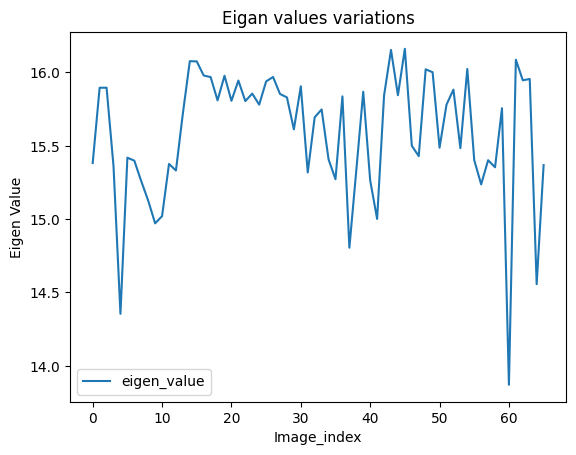

In [ ]:
ax = df.plot( y="eigen_value", kind="line")

# Customize axis labels and title
ax.set_xlabel("Image_index")
ax.set_ylabel("Eigen Value")
ax.set_title("Eigan values variations")

plt.show()

In [ ]:
df

,eigen_value,image_name
0,15.382311,dataset\rough\Screenshot 2024-10-30 172650.png
1,15.895519,dataset\rough\Screenshot 2024-10-30 172704.png
2,15.895885,dataset\rough\Screenshot 2024-10-30 172713.png
3,15.361595,dataset\rough\Screenshot 2024-10-30 172721.png
4,14.353740,dataset\rough\Screenshot 2024-10-30 172730.png
...,...,...
96,13.829794,dataset\rough\Screenshot 2024-10-30 210240.png
97,12.848773,dataset\rough\Screenshot 2024-10-30 210249.png
98,12.922426,dataset\rough\Screenshot 2024-10-30 210358.png
99,13.681525,dataset\rough\Screenshot 2024-10-30 210408.png


In [ ]:
#3. DATA LOADING

import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Set up two generators: one for the majority class and one with extra augmentation for the minority class

def load_data(train_dir, val_dir):
    # Increased data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescale for validation
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load train and validation data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator
train_dir = 'dataset_combined/train'
val_dir = 'dataset_combined/validate'

# Load the data
train_generator, validation_generator = load_data(train_dir, val_dir)


Found 124 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [ ]:
# Set up data augmentation generator
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load a single image
img_path = r'dataset_combined\validate\smooth\s49.PNG'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Set number of augmentations you want to save
num_augmented_images = 10
i = 0
for batch in augmented_datagen.flow(x, batch_size=1, save_to_dir='test', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i >= num_augmented_images:
        break  # Stop after saving the desired number of augmentations


In [ ]:
from tensorflow.keras import layers, models

def create_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))  # Added extra layer
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))  # Added extra layer
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Added dropout to reduce overfitting
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [ ]:
#5. MODEL TRAINING AND SAVING
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
# Function to train the model
def train_model(train_generator, validation_generator):
    model = create_model()

    # Compile the model with a reduced learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Calculate class weights for handling class imbalance
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with class weights and early stopping
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        class_weight=class_weights,
        callbacks=[early_stopping]
    )

    # Save the trained model
    model.save('texture_model.h5')

    return model

In [ ]:
class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.7948717948717948, 1: 1.3478260869565217}


In [ ]:
def evaluate_model(model, validation_generator):
    test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Function to predict on a single image
def predict_single_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the image to an array and preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape
    img_array /= 255.0  # Rescale if necessary

    # Predict
    prediction = model.predict(img_array)

    # Since it's a binary classification, a prediction > 0.5 can be interpreted as one class, else another
    class_label = 'Smooth' if prediction > 0.5 else 'Rough'
    print(f"Prediction: {class_label} with probability {prediction[0][0]:.4f}")




In [ ]:
#9. MAIN

def main():
    # Combined dataset directories
    train_dir = 'dataset_combined/train'
    val_dir = 'dataset_combined/validate'

    # Load data (no need for separate directories now)
    train_generator, validation_generator = load_data(train_dir, val_dir)

    # Train the model
    model = train_model(train_generator, validation_generator)

    # Evaluate the model
    evaluate_model(model, validation_generator)
    img_path = r'dataset_combined\validate\smooth\s50.PNG'  # Replace with the path to your image
    predict_single_image(model, img_path)


main()



Found 124 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


C:\Users\arham\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


C:\Users\arham\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.6337 - loss: 0.6810 - val_accuracy: 0.3548 - val_loss: 0.7241
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5016 - loss: 0.6667 - val_accuracy: 0.6452 - val_loss: 0.6632
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6292 - loss: 0.6828 - val_accuracy: 0.4516 - val_loss: 0.7019
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6593 - loss: 0.6318 - val_accuracy: 0.6129 - val_loss: 0.6997
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6638 - loss: 0.6146 - val_accuracy: 0.6452 - val_loss: 0.7240


1/1 - 1s - 718ms/step - accuracy: 0.6452 - loss: 0.6632
Test Accuracy: 64.52%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Prediction: Rough with probability 0.3609


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('texture_model.h5')
img_path = r'dataset_combined\validate\smooth\s50.PNG'  # Replace with the path to your image
predict_single_image(model, img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Prediction: Rough with probability 0.4946


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


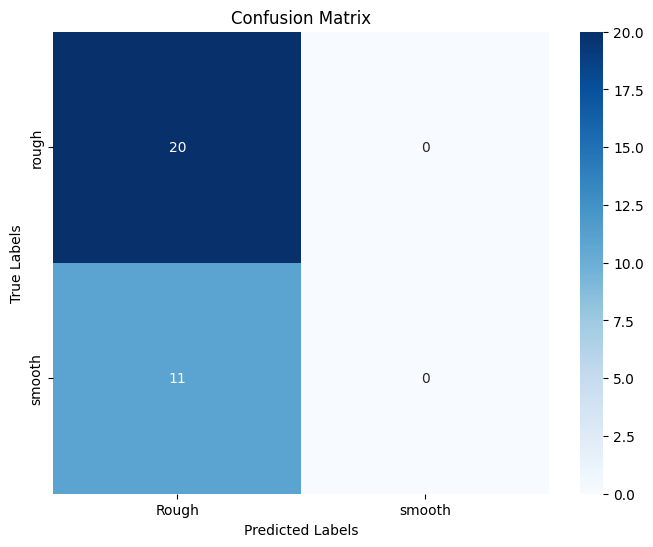

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the model
model = load_model('texture_model.h5')


# Generate predictions and true labels for the validation set
# Assuming validation_generator is the generator for your validation set
true_labels = validation_generator.classes  # True labels from the generator
predictions = model.predict(validation_generator)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary labels

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Rough', 'smooth'], yticklabels=['rough', 'smooth'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Class 0 with probability 0.0000
